<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

# Building A Multi-Arm Bandit Split Test

Week 9 | 4.1

---

In this lab you will be building a "multi-arm bandit split test" from scratch.

This is also an exercise in object-oriented python programming.

---

### Construction of the multi-arm bandit

The multi-arm bandit split test is named in reference to the [multi-arm bandit probability problem](https://en.wikipedia.org/wiki/Multi-armed_bandit) in which a gambler must decide which slot machine to play by trying different machines out and keeping track of which ones win the most.

Multi-arm bandit split tests are popular because they are able to "winner themselves". Over time, the arm with the highest probability of conversion will become the arm that nearly all new users are assigned to.

The setup of the multi-arm bandit requires surprisingly few steps:

1. Probability of arm conversion rates are represented by beta(conversions+1, not_conversions+1) distributions. Initially arms are instantiated as the beta(1,1) uniform distribution (or whatever group-level prior you choose for the betas).
- New users are assigned to arms based on random draws from the beta distributions. For example:
 - Split test has arms A, B, C represented by beta distributions.
 - Draw a random number from each arm's beta distribution.
 - The user is assigned to the arm with the highest drawn number.
- Over time, typically at fixed intervals, the beta distributions for each arm are updated with the new records of successes and failures (conversions vs. not).

You will be building a class that constructs, runs, plots, and tests metrics for a multi-arm bandit from the ground up.

---

### Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### SplitTest class

I have pre-coded a class in the `utils` folder called `SplitTest` which is loaded below. 

Once instantiated, the class will generate conversion records for arbitrary arms. You do not need to manually specify the arms themselves. As soon as you try to access any arm by name, it will create the arm for you and store it. 

Functionality is described in code below:

```python
# class is instantiated:
st = SplitTest()
#
# getting conversions for an arm is as simple as calling the arm
# (which does not need to be instantiated itself!)
st.A()
> Creating split test arm: A
> array([1])
#
# Results are returned in an array. You can specify a number of
# users to get more conversion results.
# Notice that the "Creating split test.." print out does not 
# appear here. This is because arm A has already been created
# by our previous call.
st.A(5)
> array([0, 0, 0, 1, 0])
#
# Results for an arm are generated according to that arm's hidden
# true rate, persistent across all calls.
# Arms can be arbitrarily named, and both created and accessed by
# either the attribute syntax or the dictionary key syntax.
st['B']
> Creating split test arm: B
> <split_test.SplitTestArm at 0x118319f90>
#
# As you can see above, without the function call parentheses the 
# internal SplitTestArm object is returned.
# Function calls can be placed on the end of the key style
# accessor, since either keys or attributes both return the
# intantiation of that particular arm.
st['Arm_C'](2)
> Creating split test arm: Arm_C
> array([0, 0])
#
# If you re-instantiate st, then the arms from the original are
# erased since you have recreated the entire class.
st = SplitTest()
st.A()
> Creating split test arm: A
> array([0])
```

You will be using this class to get conversion rates for users. The class will store the conversion generating functions for the arms in your multi-arm bandit. 

In [2]:
import imp
split_test = imp.load_source('split_test', '/Users/kiefer/github-repos/DSI-SF-2/utils/split_test/split_test_generator.py')
from split_test import SplitTest

st = SplitTest()

---

### 1. Create the `MultiArmBandit` class

Write the class definition and the `__init__` function. There should at least be a class attribute with an instantiated SplitTest object.

Feel free to add more now if you like; you will be adding more incrementally throughout these sections.

In [3]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object):
        self.st_obj = split_test_object
        

---

### 2. Add a function to create arms for your split test

- This function should be able to create a split test arm given a specified name. 
- You will need to store information about the performance of your arms, such as number of people who converted and did not convert for any particular arm.
- You will also need to have a container for the beta distributions for each arm. When an arm is first created, give it a `stats.beta(1,1)` beta distribution (equivalent to uniform prior).

In [4]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object):
        self.st_obj = split_test_object
        self.st_arms = {}
        self.st_arm_betas = {}
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        

---

### 3. Add a function to assign users to an arm and update conversion information

- This function will get conversions for a specified number of users for a specified arm.
- To get the conversions for an arm, you will be using the split test object that you made a class attribute.
- Update the number of current successes and failures for that arm.

In [5]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object):
        self.st_obj = split_test_object
        self.st_arms = {}
        self.st_arm_betas = {}
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        
        
    def assign_users_to_arm(self, arm_name, n=1):
        if not arm_name in self.st_arms.keys():
            self.create_arm(arm_name)
            
        conversions = self.st_obj[arm_name](n)
        
        self.st_arms[arm_name]['successes'] += np.sum(conversions)
        self.st_arms[arm_name]['failures'] += (len(conversions) - np.sum(conversions))
        
        print arm_name, 'converted:', self.st_arms[arm_name]['successes']
        print arm_name, 'did not convert:', self.st_arms[arm_name]['failures']
        

---

### 4. Add a function to update beta distributions for the arms.

- This function will iterate through the arms in your test and update their beta distributions according to how many successes and failures each arm has.

In [6]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object):
        self.st_obj = split_test_object
        self.st_arms = {}
        self.st_arm_betas = {}
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        
        
    def assign_users_to_arm(self, arm_name, n=1):
        if not arm_name in self.st_arms.keys():
            self.create_arm(arm_name)
            
        conversions = self.st_obj[arm_name](n)
        
        self.st_arms[arm_name]['successes'] += np.sum(conversions)
        self.st_arms[arm_name]['failures'] += (len(conversions) - np.sum(conversions))
        
        print arm_name, 'converted:', self.st_arms[arm_name]['successes']
        print arm_name, 'did not convert:', self.st_arms[arm_name]['failures']
     
    
    def update_arm_beta_dist(self):
        for arm_name in self.st_arms.keys():
            alpha = self.st_arms[arm_name]['successes'] + 1
            beta = self.st_arms[arm_name]['failures'] + 1
            print 'Updating', arm_name, 'distribution to beta(%d, %d)', (alpha, beta)
            self.st_arm_betas[arm_name] = stats.beta(alpha, beta)

---

### 5. Add a function to plot beta distributions and mean conversion rates per arm

- The arms should be plotted as different colors and properly labeled.

In [7]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object):
        self.st_obj = split_test_object
        self.st_arms = {}
        self.st_arm_betas = {}
        self.colors = ['#1F77B4','#FF7F0E','#2CA02C','#D62728',
                       '#9467BD','#8C564B','#E377C2','#7F7F7F',
                       '#BCBD22','#17BECF']
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        
        
    def assign_users_to_arm(self, arm_name, n=1):
        if not arm_name in self.st_arms.keys():
            self.create_arm(arm_name)
            
        conversions = self.st_obj[arm_name](n)
        
        self.st_arms[arm_name]['successes'] += np.sum(conversions)
        self.st_arms[arm_name]['failures'] += (len(conversions) - np.sum(conversions))
        
        print arm_name, 'converted:', self.st_arms[arm_name]['successes']
        print arm_name, 'did not convert:', self.st_arms[arm_name]['failures']
     
    
    def update_arm_beta_dists(self):
        for arm_name in self.st_arms.keys():
            alpha = self.st_arms[arm_name]['successes'] + 1
            beta = self.st_arms[arm_name]['failures'] + 1
            print 'Updating', arm_name, 'distribution to beta(%d, %d)' % (alpha, beta)
            self.st_arm_betas[arm_name] = stats.beta(alpha, beta)
            
    
    def plot_arm_betas(self):
        fig, ax = plt.subplots(figsize=(10,5))
        x_vals = np.linspace(0,1,200)
        for i, arm_name in enumerate(self.st_arms.keys()):
            arm_pdf = self.st_arm_betas[arm_name].pdf(x_vals)
            # add a random jitter so that they dont totally overlap
            # if the betas are the same...
            x_vals_jitter = x_vals + (np.random.rand()/100.)
            x_vals_jitter = np.maximum(x_vals_jitter, 0.)
            x_vals_jitter = np.minimum(x_vals_jitter, 1.)
            
            successes = float(self.st_arms[arm_name]['successes'])
            failures = float(self.st_arms[arm_name]['failures'])
            
            ax.plot(x_vals_jitter, arm_pdf, lw=3, color=self.colors[i], 
                    label=arm_name, alpha=0.85)
            
            if failures == 0:
                ax.axvline(1., lw=4, color=self.colors[i], ls='dashed',
                           alpha=0.85)
            elif not (successes + failures) == 0:
                ax.axvline((successes / (successes + failures)), lw=4, 
                           color=self.colors[i], ls='dashed', alpha=0.85)
        
        ax.legend(loc='upper right')
        plt.show()
        

In [8]:
np.maximum([1,2,3],2)

array([2, 2, 3])

---

### 6. Test out your `MultiArmBandit` class

1. Create 4 arms.
2. Run 50 users for each arm.
3. Update the arm beta distributions.
4. Plot the betas.

In [9]:
mab = MultiArmBandit(st)

In [10]:
mab.create_arm('A')
mab.create_arm('B')
mab.create_arm('C')
mab.create_arm('D')

Creating arm A and success/failure records
Creating beta(1, 1) distribution for arm A
Creating arm B and success/failure records
Creating beta(1, 1) distribution for arm B
Creating arm C and success/failure records
Creating beta(1, 1) distribution for arm C
Creating arm D and success/failure records
Creating beta(1, 1) distribution for arm D


In [11]:
mab.assign_users_to_arm('A', n=50)
mab.assign_users_to_arm('B', n=50)
mab.assign_users_to_arm('C', n=50)
mab.assign_users_to_arm('D', n=50)

Creating split test arm: A
A converted: 3
A did not convert: 47
Creating split test arm: B
B converted: 13
B did not convert: 37
Creating split test arm: C
C converted: 11
C did not convert: 39
Creating split test arm: D
D converted: 10
D did not convert: 40


In [12]:
mab.update_arm_beta_dists()

Updating A distribution to beta(4, 48)
Updating C distribution to beta(12, 40)
Updating B distribution to beta(14, 38)
Updating D distribution to beta(11, 41)


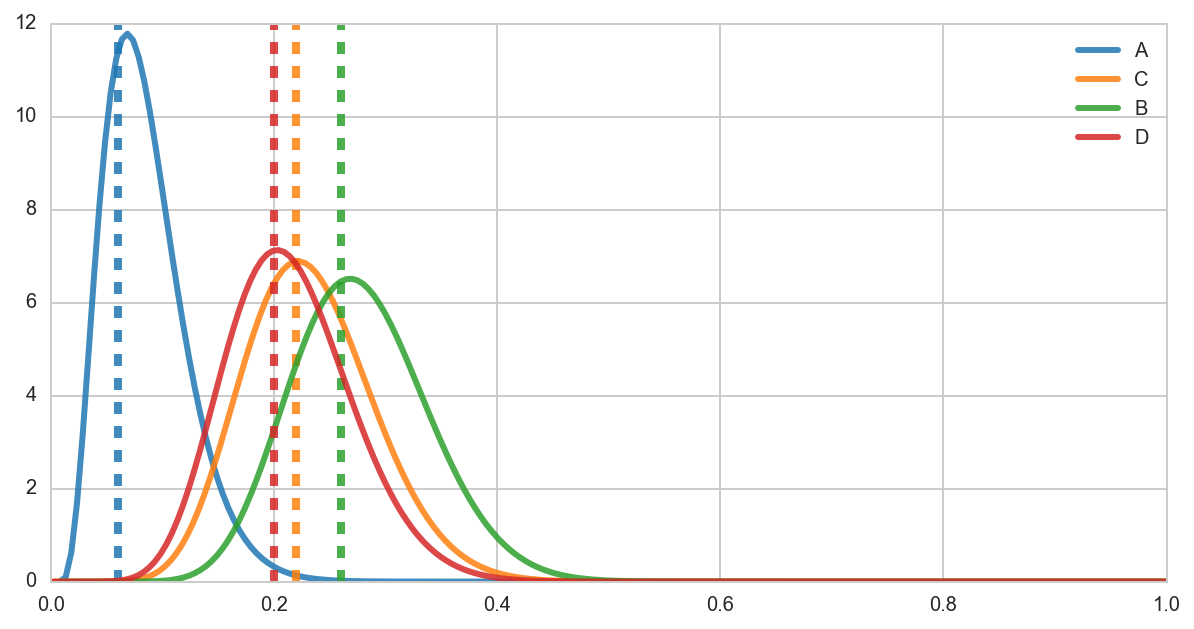

In [13]:
mab.plot_arm_betas()

---

### 7. Add a function that assigns user(s) to an arm based on random draws from the arm beta distributions

In the multi-arm bandit, the assignment of a user to an arm is probabilistic. Instead of assigning a number of users to an arm directly, write a function that first determines which arm to assign the user to based on random draws from the arm beta distributions.

1. Draw a random value from each arm's beta distribution.
2. Determine the arm with the higest random value.
3. Assign the user to the selected arm.

If you are assigning multiple users with this function, make sure that you perform the random draws for each user individually.

In [14]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object):
        self.st_obj = split_test_object
        self.st_arms = {}
        self.st_arm_betas = {}
        self.colors = ['#1F77B4','#FF7F0E','#2CA02C','#D62728',
                       '#9467BD','#8C564B','#E377C2','#7F7F7F',
                       '#BCBD22','#17BECF']
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        
        
    def assign_users_to_arm(self, arm_name, n=1, verbose=False):
        if not arm_name in self.st_arms.keys():
            self.create_arm(arm_name)
            
        conversions = self.st_obj[arm_name](n)
        
        self.st_arms[arm_name]['successes'] += np.sum(conversions)
        self.st_arms[arm_name]['failures'] += (len(conversions) - np.sum(conversions))
        
        if verbose:
            print arm_name, 'converted:', self.st_arms[arm_name]['successes']
            print arm_name, 'did not convert:', self.st_arms[arm_name]['failures']
        
    
    def assign_users(self, n=1):
        for i in range(n):
            random_p = 0.0
            winning_arm = None
            for arm_name, arm_beta in self.st_arm_betas.items():
                p = arm_beta.rvs()
                if p >= random_p:
                    winning_arm = arm_name
                    random_p = p
            self.assign_users_to_arm(winning_arm, n=1)
     
    
    def update_arm_beta_dists(self):
        for arm_name in self.st_arms.keys():
            alpha = self.st_arms[arm_name]['successes'] + 1
            beta = self.st_arms[arm_name]['failures'] + 1
            print 'Updating', arm_name, 'distribution to beta(%d, %d)' % (alpha, beta)
            self.st_arm_betas[arm_name] = stats.beta(alpha, beta)
            
    
    def plot_arm_betas(self):
        fig, ax = plt.subplots(figsize=(10,5))
        x_vals = np.linspace(0,1,200)
        for i, arm_name in enumerate(self.st_arms.keys()):
            arm_pdf = self.st_arm_betas[arm_name].pdf(x_vals)
            # add a random jitter so that they dont totally overlap
            # if the betas are the same...
            x_vals_jitter = x_vals + (np.random.rand()/100.)
            x_vals_jitter = np.maximum(x_vals_jitter, 0.)
            x_vals_jitter = np.minimum(x_vals_jitter, 1.)
            
            successes = float(self.st_arms[arm_name]['successes'])
            failures = float(self.st_arms[arm_name]['failures'])
            
            ax.plot(x_vals_jitter, arm_pdf, lw=3, color=self.colors[i], 
                    label=arm_name, alpha=0.85)
            
            if failures == 0:
                ax.axvline(1., lw=4, color=self.colors[i], ls='dashed',
                           alpha=0.85)
            elif not (successes + failures) == 0:
                ax.axvline((successes / (successes + failures)), lw=4, 
                           color=self.colors[i], ls='dashed', alpha=0.85)
        
        ax.legend(loc='upper right')
        plt.show()
        

---

### 8. Modify your function so that the beta distributions for arms will be updated at specific intervals of users

For example, you should be able to instantiate the class with something like:

```python
mab = MultiArmBandit(st, beta_update_interval=50)
```

And the result would be that for every 50 users _total_, as in, across all arms, the beta distributions for your arms get updated.

In other words, if I set `beta_update_interval=50`, then every 50 users assigned in general the function to update the beta distributions would be called before assigning more users.

The implementation of this logic is up to you.

In [15]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object, beta_update_interval=50):
        self.st_obj = split_test_object
        self.beta_update_interval = beta_update_interval
        self.st_arms = {}
        self.st_arm_betas = {}
        self.total_users = 0
        self.colors = ['#1F77B4','#FF7F0E','#2CA02C','#D62728',
                       '#9467BD','#8C564B','#E377C2','#7F7F7F',
                       '#BCBD22','#17BECF']
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        
        
    def assign_users_to_arm(self, arm_name, n=1, verbose=False):
        if not arm_name in self.st_arms.keys():
            self.create_arm(arm_name)
            
        for i in range(n):
            if (self.total_users > 0) and (self.total_users % self.beta_update_interval == 0):
                self.update_arm_beta_dists()
                print '--------------------------------------------------\n'
            self.total_users += 1
            
            conversions = self.st_obj[arm_name]()

            self.st_arms[arm_name]['successes'] += np.sum(conversions)
            self.st_arms[arm_name]['failures'] += (len(conversions) - np.sum(conversions))

            if verbose:
                print arm_name, 'converted:', self.st_arms[arm_name]['successes']
                print arm_name, 'did not convert:', self.st_arms[arm_name]['failures']
        
    
    def assign_users(self, n=1):
        for i in range(n):
            random_p = 0.0
            winning_arm = None
            for arm_name, arm_beta in self.st_arm_betas.items():
                p = arm_beta.rvs()
                if p >= random_p:
                    winning_arm = arm_name
                    random_p = p
            self.assign_users_to_arm(winning_arm, n=1)
        self.update_arm_beta_dists()
     
    
    def update_arm_beta_dists(self):
        for arm_name in self.st_arms.keys():
            alpha = self.st_arms[arm_name]['successes'] + 1
            beta = self.st_arms[arm_name]['failures'] + 1
            print 'Updating', arm_name, 'distribution to beta(%d, %d)' % (alpha, beta)
            self.st_arm_betas[arm_name] = stats.beta(alpha, beta)
            
    
    def plot_arm_betas(self):
        fig, ax = plt.subplots(figsize=(10,5))
        x_vals = np.linspace(0,1,200)
        for i, arm_name in enumerate(self.st_arms.keys()):
            arm_pdf = self.st_arm_betas[arm_name].pdf(x_vals)
            # add a random jitter so that they dont totally overlap
            # if the betas are the same...
            x_vals_jitter = x_vals + (np.random.rand()/100.)
            x_vals_jitter = np.maximum(x_vals_jitter, 0.)
            x_vals_jitter = np.minimum(x_vals_jitter, 1.)
            
            successes = float(self.st_arms[arm_name]['successes'])
            failures = float(self.st_arms[arm_name]['failures'])
            
            ax.plot(x_vals_jitter, arm_pdf, lw=3, color=self.colors[i], 
                    label=arm_name, alpha=0.85)
            
            if failures == 0:
                ax.axvline(1., lw=4, color=self.colors[i], ls='dashed',
                           alpha=0.85)
            elif not (successes + failures) == 0:
                ax.axvline((successes / (successes + failures)), lw=4, 
                           color=self.colors[i], ls='dashed', alpha=0.85)
        
        ax.legend(loc='upper right')
        plt.show()

---

### 9. Run a multi-arm bandit across 200 users, updating the betas every 25 users

Plot the betas as well.

NOTE: You will probably want to add a final beta update call once the user assignments are complete so that the beta distributions plot correctly with the mean rates.

In [16]:
mab = MultiArmBandit(st, beta_update_interval=25)

In [17]:
for arm_name in ['A','B','C','D']:
    mab.create_arm(arm_name)
    

Creating arm A and success/failure records
Creating beta(1, 1) distribution for arm A
Creating arm B and success/failure records
Creating beta(1, 1) distribution for arm B
Creating arm C and success/failure records
Creating beta(1, 1) distribution for arm C
Creating arm D and success/failure records
Creating beta(1, 1) distribution for arm D


In [18]:
mab.assign_users(n=200)

Updating A distribution to beta(1, 4)
Updating C distribution to beta(3, 7)
Updating B distribution to beta(2, 5)
Updating D distribution to beta(1, 10)
--------------------------------------------------

Updating A distribution to beta(1, 7)
Updating C distribution to beta(7, 17)
Updating B distribution to beta(4, 10)
Updating D distribution to beta(1, 11)
--------------------------------------------------

Updating A distribution to beta(1, 9)
Updating C distribution to beta(8, 25)
Updating B distribution to beta(6, 20)
Updating D distribution to beta(2, 12)
--------------------------------------------------

Updating A distribution to beta(2, 11)
Updating C distribution to beta(9, 39)
Updating B distribution to beta(7, 26)
Updating D distribution to beta(2, 12)
--------------------------------------------------

Updating A distribution to beta(2, 17)
Updating C distribution to beta(11, 44)
Updating B distribution to beta(8, 35)
Updating D distribution to beta(3, 13)
----------------

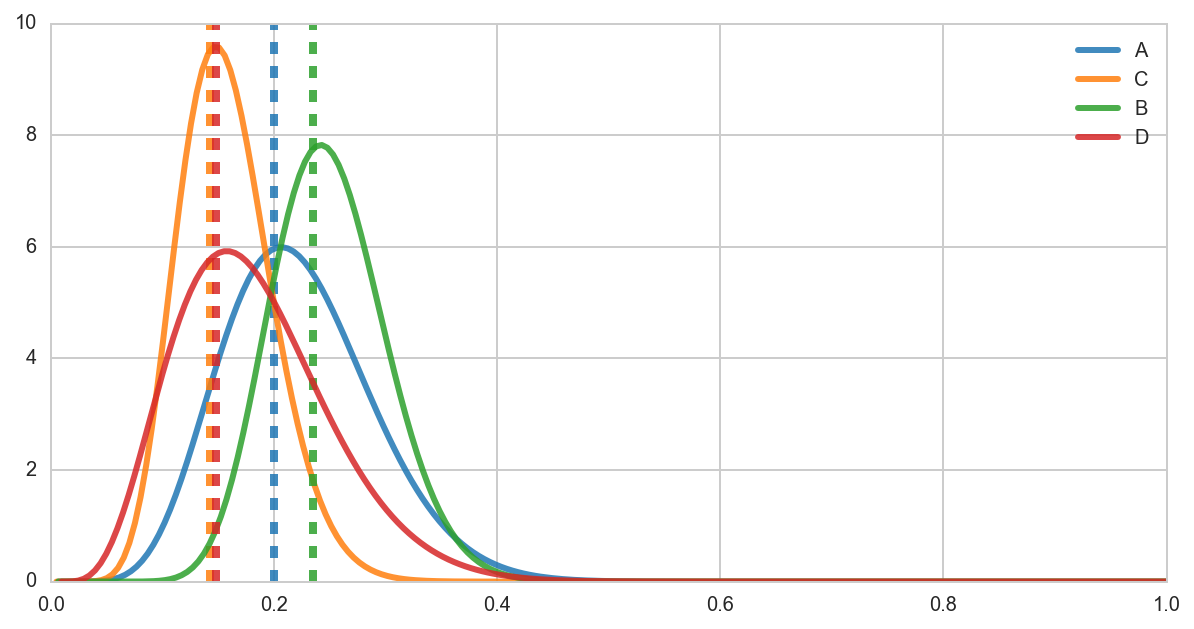

In [19]:
mab.plot_arm_betas()

In [20]:
print st.A._true_rate
print st.B._true_rate
print st.C._true_rate
print st.D._true_rate

0.140018285976
0.150132466462
0.190877350039
0.206945984437


---

### 10. Compare this to a standard A/B test setup with 50 users assigned to each arm.

You can still do this with the same class, but you may need to set your beta update value to be higher than 50 to prevent them from updating.

In [21]:
ab_vanilla = MultiArmBandit(st, beta_update_interval=1000)
for arm_name in ['A','B','C','D']:
    ab_vanilla.create_arm(arm_name)
    ab_vanilla.assign_users_to_arm(arm_name, n=50)
ab_vanilla.update_arm_beta_dists()

Creating arm A and success/failure records
Creating beta(1, 1) distribution for arm A
Creating arm B and success/failure records
Creating beta(1, 1) distribution for arm B
Creating arm C and success/failure records
Creating beta(1, 1) distribution for arm C
Creating arm D and success/failure records
Creating beta(1, 1) distribution for arm D
Updating A distribution to beta(2, 50)
Updating C distribution to beta(13, 39)
Updating B distribution to beta(8, 44)
Updating D distribution to beta(11, 41)


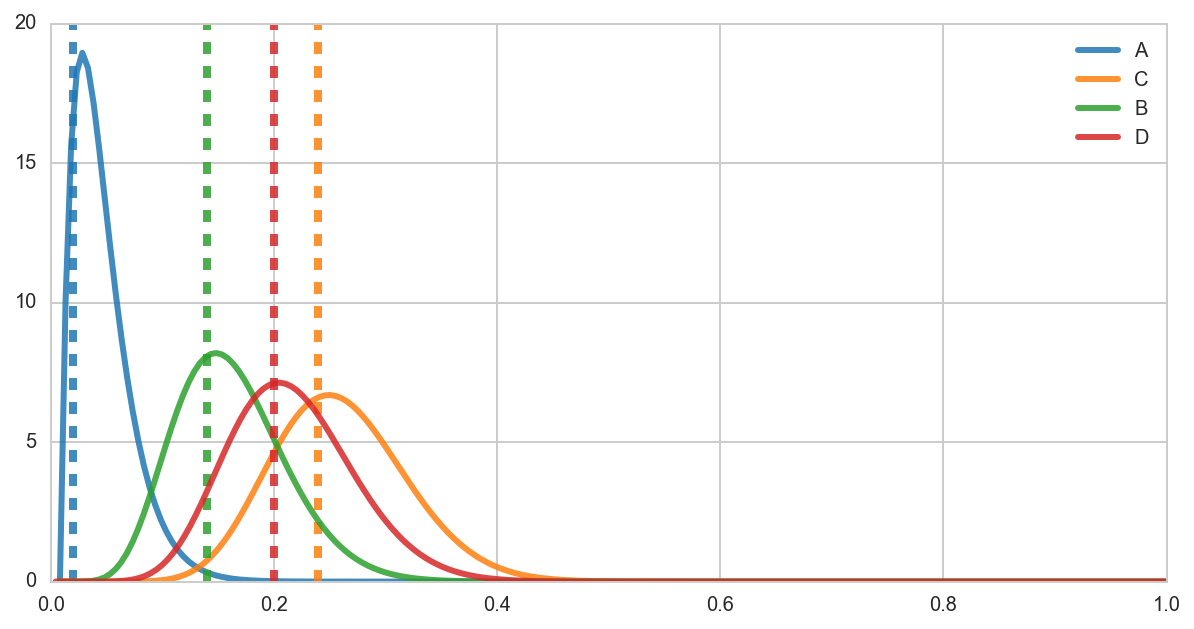

In [22]:
ab_vanilla.plot_arm_betas()

In [23]:
print st.A._true_rate
print st.B._true_rate
print st.C._true_rate
print st.D._true_rate

0.140018285976
0.150132466462
0.190877350039
0.206945984437


---

### 11. Add a function to calculate and plot a distribution of differences between arms.

This will be similar (but not exactly the same) as the `AvB` arm difference distributions we were calculating in pymc3 in the last lab.

For two arms, your function should:

1. Draw a given number of random values from each arm (1000 is good).
2. Calculate a vector of differences between the two arms.
3. Plot the distribution of differences between arms.
4. Indicate the percent of above-zero values in the distribution.

Optionally, you may want to plot a vertical line through zero like `pm.plot_posterior` does for reference.

In [24]:
class MultiArmBandit(object):
    
    def __init__(self, split_test_object, beta_update_interval=50):
        self.st_obj = split_test_object
        self.beta_update_interval = beta_update_interval
        self.st_arms = {}
        self.st_arm_betas = {}
        self.total_users = 0
        self.colors = ['#1F77B4','#FF7F0E','#2CA02C','#D62728',
                       '#9467BD','#8C564B','#E377C2','#7F7F7F',
                       '#BCBD22','#17BECF']
        
    
    def create_arm(self, arm_name):
        print 'Creating arm', arm_name, 'and success/failure records'
        self.st_arms[arm_name] = {
            'successes':0,
            'failures':0
        }
        print 'Creating beta(1, 1) distribution for arm', arm_name
        self.st_arm_betas[arm_name] = stats.beta(1, 1)
        
        
    def assign_users_to_arm(self, arm_name, n=1, verbose=False):
        if not arm_name in self.st_arms.keys():
            self.create_arm(arm_name)
            
        for i in range(n):
            if (self.total_users > 0) and (self.total_users % self.beta_update_interval == 0):
                self.update_arm_beta_dists()
                print '--------------------------------------------------\n'
            self.total_users += 1
            
            conversions = self.st_obj[arm_name]()

            self.st_arms[arm_name]['successes'] += np.sum(conversions)
            self.st_arms[arm_name]['failures'] += (len(conversions) - np.sum(conversions))

            if verbose:
                print arm_name, 'converted:', self.st_arms[arm_name]['successes']
                print arm_name, 'did not convert:', self.st_arms[arm_name]['failures']
        
    
    def assign_users(self, n=1):
        for i in range(n):
            random_p = 0.0
            winning_arm = None
            for arm_name, arm_beta in self.st_arm_betas.items():
                p = arm_beta.rvs()
                if p >= random_p:
                    winning_arm = arm_name
                    random_p = p
            self.assign_users_to_arm(winning_arm, n=1)
        self.update_arm_beta_dists()
     
    
    def update_arm_beta_dists(self):
        for arm_name in self.st_arms.keys():
            alpha = self.st_arms[arm_name]['successes'] + 1
            beta = self.st_arms[arm_name]['failures'] + 1
            print 'Updating', arm_name, 'distribution to beta(%d, %d)' % (alpha, beta)
            self.st_arm_betas[arm_name] = stats.beta(alpha, beta)
            
    
    def plot_arm_betas(self):
        fig, ax = plt.subplots(figsize=(10,5))
        x_vals = np.linspace(0,1,200)
        for i, arm_name in enumerate(self.st_arms.keys()):
            arm_pdf = self.st_arm_betas[arm_name].pdf(x_vals)
            # add a random jitter so that they dont totally overlap
            # if the betas are the same...
            x_vals_jitter = x_vals + (np.random.rand()/100.)
            x_vals_jitter = np.maximum(x_vals_jitter, 0.)
            x_vals_jitter = np.minimum(x_vals_jitter, 1.)
            
            successes = float(self.st_arms[arm_name]['successes'])
            failures = float(self.st_arms[arm_name]['failures'])
            
            ax.plot(x_vals_jitter, arm_pdf, lw=3, color=self.colors[i], 
                    label=arm_name, alpha=0.85)
            
            if failures == 0:
                ax.axvline(1., lw=4, color=self.colors[i], ls='dashed',
                           alpha=0.85)
            elif not (successes + failures) == 0:
                ax.axvline((successes / (successes + failures)), lw=4, 
                           color=self.colors[i], ls='dashed', alpha=0.85)
        
        ax.legend(loc='upper right')
        plt.show()
        
        
    def plot_arm_delta_dist(self, arm1, arm2, draws=1000):
        arm1_beta = self.st_arm_betas[arm1]
        arm2_beta = self.st_arm_betas[arm2]
        
        arm1_draws = arm1_beta.rvs(1000)
        arm2_draws = arm2_beta.rvs(1000)
        
        deltas = arm1_draws - arm2_draws
        
        pct_above_zero = float(np.sum(deltas > 0)) / len(deltas)
        
        fig, ax = plt.subplots(figsize=(8,5))
        
        ax.hist(deltas, bins=30, color='#87ceeb', 
                label='{0:.2f}'.format(pct_above_zero)+'% > 0')
        
        ax.axvline(0., lw=5, ls='dashed', alpha=0.8, color='darkgoldenrod')
        
        ax.set_title(arm1+' vs. '+arm2+' conversion rate difference\n', fontsize=20)
        ax.set_xlabel('delta', fontsize=16)
        ax.set_ylabel('frequency', fontsize=16)
        
        ax.legend(loc='upper right')
        
        plt.show()
        

In [25]:
mab = MultiArmBandit(st, beta_update_interval=25)
for arm_name in ['A','B','C','D']:
    mab.create_arm(arm_name)
mab.assign_users(n=200)

Creating arm A and success/failure records
Creating beta(1, 1) distribution for arm A
Creating arm B and success/failure records
Creating beta(1, 1) distribution for arm B
Creating arm C and success/failure records
Creating beta(1, 1) distribution for arm C
Creating arm D and success/failure records
Creating beta(1, 1) distribution for arm D
Updating A distribution to beta(1, 9)
Updating C distribution to beta(2, 2)
Updating B distribution to beta(2, 5)
Updating D distribution to beta(5, 7)
--------------------------------------------------

Updating A distribution to beta(1, 9)
Updating C distribution to beta(5, 12)
Updating B distribution to beta(2, 10)
Updating D distribution to beta(8, 11)
--------------------------------------------------

Updating A distribution to beta(1, 10)
Updating C distribution to beta(8, 16)
Updating B distribution to beta(2, 11)
Updating D distribution to beta(9, 26)
--------------------------------------------------

Updating A distribution to beta(1, 11

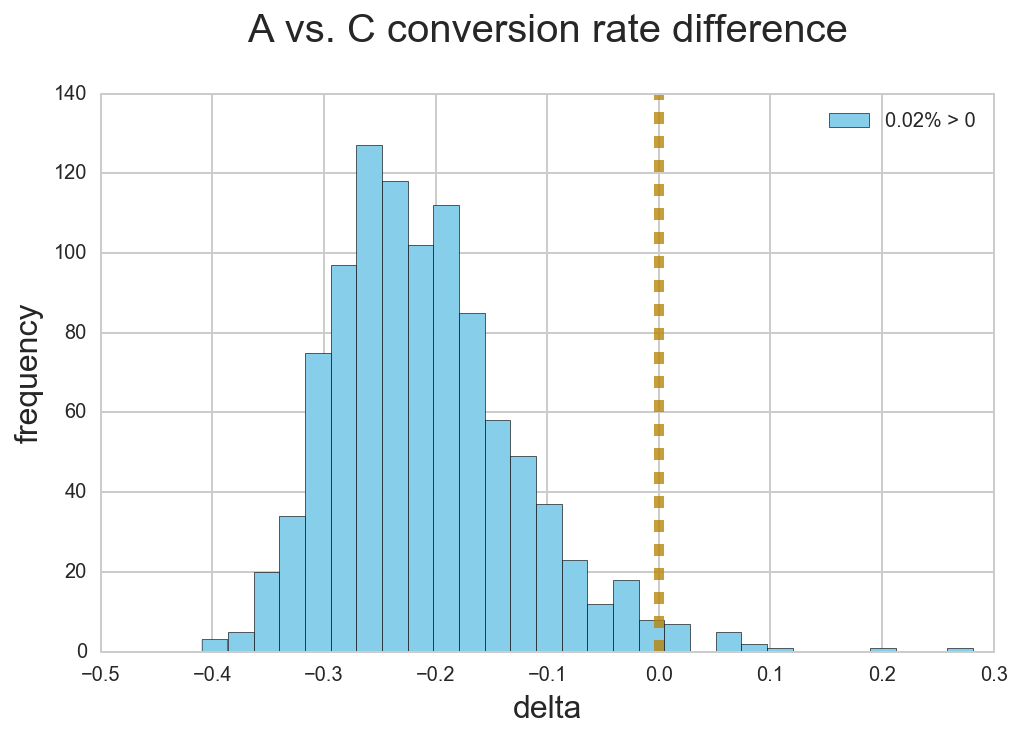

In [26]:
mab.plot_arm_delta_dist('A','C')

---

### 12. [BONUS] Make an interactive widget of the multi-arm bandit betas updating over time

Refer back to the DBSCAN lesson to find sample code on how to make an interactive widget.

You'll need to modify the class to keep track of either the betas or success/failure rates over time (or both) in order to properly code your interactive widget animation. As it currently stands the implementation is overwriting the historical successes and failures.